# Pluralistic Approach to Decoding Motor Activity from Different Regions in the Rodent Brain
##### Project Contributors: Narotam Singh, Vaibhav, Rishika Mohanta, Prakriti Nayak

##### Done as part of [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content) July 13-31 2020

## Population Spike Code Approach Pipeline

The original data is from Steinmetz, Nicholas A., et al. "Distributed coding of choice, action and engagement across the mouse brain." Nature 576.7786 (2019): 266-273. It was then further cleaned to consider only recordings from motor related areas with more than 50 neurons from atleast 2 mice. We only considered the the open loop condition ie. data between stimulus onset and go cue to avoid representations of moving stimulus from appearing in the neural data we are analysing. 

Here we analyse the data generated from the GLM Pipeline

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy import stats
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

### Import Dataset

In [2]:
alldat = np.load('../cleaned_dataset/train.npz',allow_pickle=True)['arr_0']

## Analysis of Dataset

First, lets quantify the number of mice, brain areas, sessions, trials, and neurons we have.

In [3]:
## Initialize dictionary
areas = {}
for i in set(np.concatenate([np.unique(i['brain_area']) for i in alldat])):
    areas[i] = {'session_count':0,'mice':[],'neuron_count':0,'trial_count':0}

## Fill dictionary with data
for i in alldat:
    for j in np.unique(i['brain_area']):
        areas[j]['neuron_count'] += sum(i['brain_area']==j)        
        areas[j]['session_count'] +=1
        areas[j]['trial_count'] +=i['spks'].shape[1]
        if i['mouse_name'] not in areas[j]['mice']: 
            areas[j]['mice'].append(i['mouse_name'])

# Print output
for i in areas:
    print(f"{i:4s} : {areas[i]['session_count']:2d} Sessions, {len(areas[i]['mice'])} Mice, {areas[i]['neuron_count']:4d} Neurons, {areas[i]['trial_count']:4d} Trials")

VPL  :  3 Sessions, 2 Mice,  251 Neurons,  706 Trials
MOs  : 12 Sessions, 9 Mice, 1548 Neurons, 2535 Trials
SSp  :  2 Sessions, 2 Mice,  441 Neurons,  203 Trials
SCig :  4 Sessions, 2 Mice,  807 Neurons,  621 Trials
MOp  :  3 Sessions, 3 Mice,  793 Neurons,  480 Trials
VPM  :  3 Sessions, 2 Mice,  322 Neurons,  623 Trials
CP   :  5 Sessions, 5 Mice, 1215 Neurons,  993 Trials
SCm  :  3 Sessions, 2 Mice,  199 Neurons,  564 Trials
SNr  :  2 Sessions, 2 Mice,  246 Neurons,  446 Trials
MD   :  3 Sessions, 3 Mice,  397 Neurons,  641 Trials


Secondly, lets look at the distribution of motor output (```wheel```) across different trials in all sessions 

In [4]:
motor_output_bins = np.arange(-20,21,1)
histograms = []
for i in alldat:
    for n,j in enumerate(i['wheel'][0]):
        start = int(i["stim_onset"]/i["bin_size"])
        end = int((i["stim_onset"]+i["gocue"][n])/i["bin_size"])
        histograms.append(np.histogram(j[start:end],bins=motor_output_bins)[0])

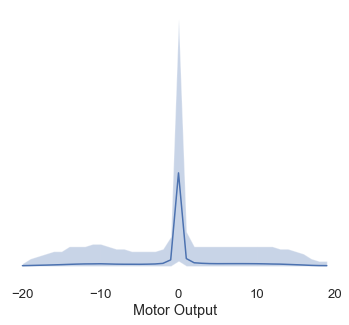

In [5]:
plt.figure(figsize=(6,5))
sns.set(font_scale=1.2)
plt.plot(motor_output_bins[:-1],np.array(histograms).mean(axis=0))
plt.fill_between(motor_output_bins[:-1],
                np.quantile(np.array(histograms),0.025,axis=0),
                np.quantile(np.array(histograms),0.975,axis=0),
                alpha=0.3)
plt.box(False)
plt.gca().set_yticklabels([])
plt.gca().set_yticks([])
plt.xlabel("Motor Output")
plt.show()

## Analysis of GLM pipeline results

In [6]:
df = pd.read_pickle('../results/results.pkl')
df = df.sort_values('Brain_Areas')
df.head()

,#Session_Number,Brain_Areas,Optimal_d,#Neurons_Used,Train_index,Test_index,Model,Correlation_Coefficient,R2_score
179,5,CP,10,"[[117, 104, 211, 95, 256, 241, 34, 192, 233, 1...","[[218, 251, 48, 171, 222, 217, 154, 58, 32, 13...","[[146, 241, 17, 78, 81, 164, 194, 162, 200, 26...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.649709,0.387306
161,5,CP,12,"[[82, 215, 108, 161, 47, 171, 140, 19, 15, 164...","[[255, 20, 189, 105, 64, 39, 162, 97, 174, 138...","[[129, 225, 193, 159, 70, 251, 217, 107, 86, 1...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.506668,0.211057
162,5,CP,25,"[[138, 69, 30, 199, 144, 4, 222, 191, 139, 212...","[[206, 148, 143, 10, 78, 159, 243, 112, 17, 13...","[[141, 183, 82, 4, 8, 34, 118, 223, 196, 122, ...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.810745,0.637388
163,5,CP,20,"[[11, 48, 54, 79, 215, 72, 87, 267, 214, 110, ...","[[253, 168, 235, 172, 6, 230, 174, 69, 265, 93...","[[108, 66, 55, 90, 40, 152, 21, 64, 89, 179, 2...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.667717,0.379323
164,5,CP,17,"[[93, 220, 192, 217, 199, 53, 140, 248, 76, 15...","[[152, 266, 13, 117, 244, 268, 115, 169, 97, 2...","[[229, 132, 213, 66, 11, 264, 65, 36, 61, 184,...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.690910,0.475625


### Analysis of R2 and Correlation Coefficient

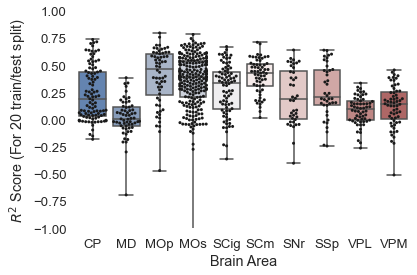

In [7]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((-1,1))
sns.boxplot(x='Brain_Areas',y='R2_score',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='R2_score',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel(r'$R^2$ Score (For 20 train/test split)')
plt.xlabel('Brain Area')
plt.show()

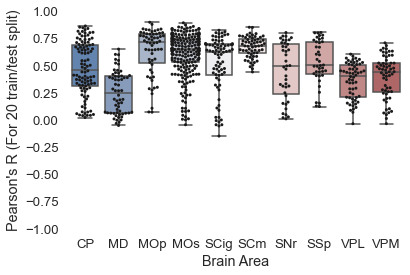

In [8]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((-1,1))
sns.boxplot(x='Brain_Areas',y='Correlation_Coefficient',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='Correlation_Coefficient',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Pearson's R (For 20 train/test split)")
plt.xlabel('Brain Area')
plt.show()

#### Correlation between R2 and Correlation Analysis

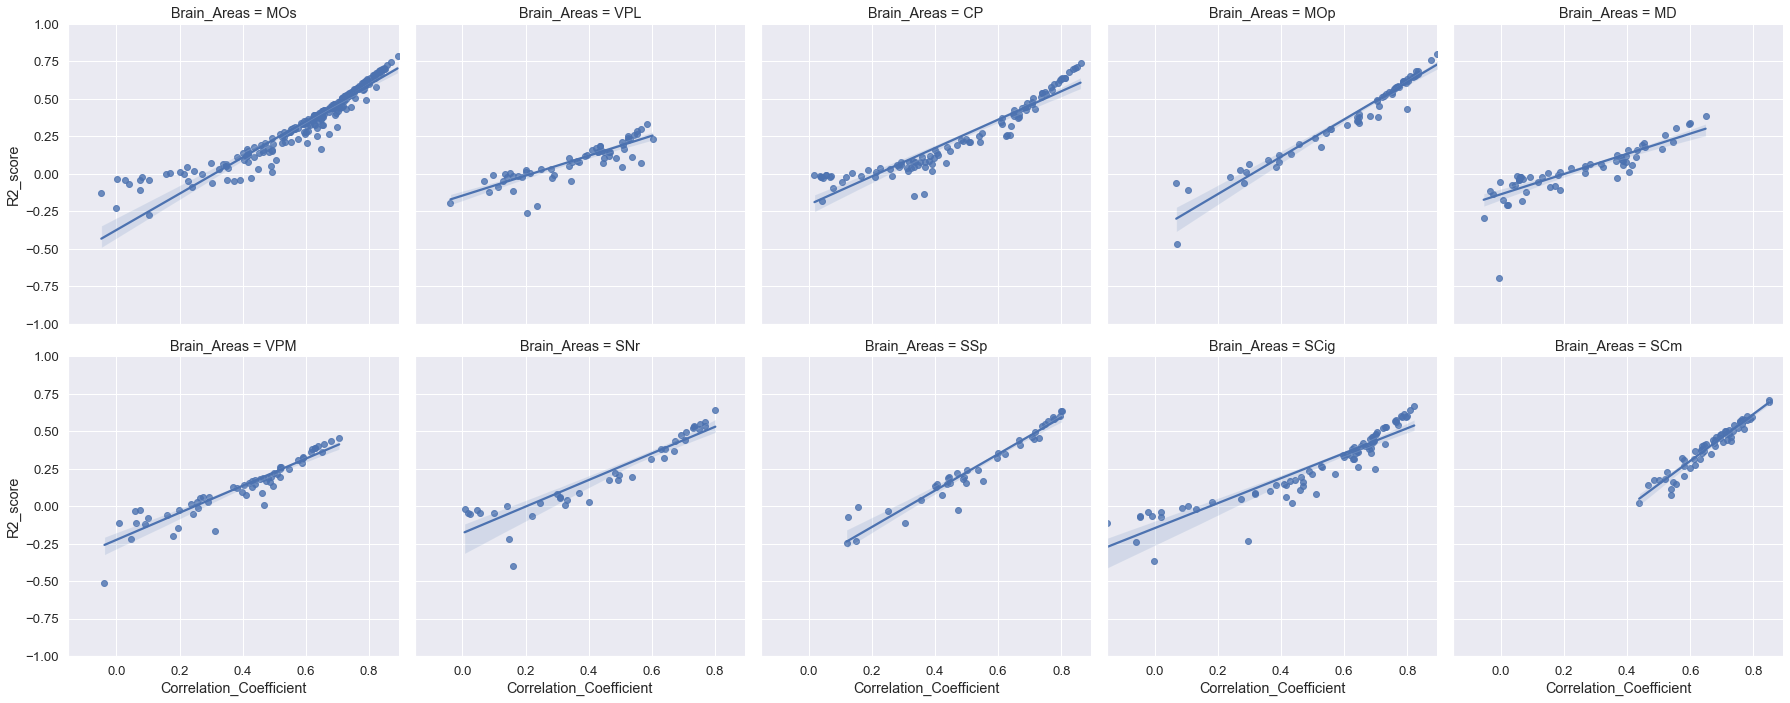

In [9]:
g = sns.lmplot('Correlation_Coefficient','R2_score',data=df,col='Brain_Areas',robust=True,col_wrap=5)
g.set(ylim=(-1,1))

#### Sensitivity to Session Id 

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


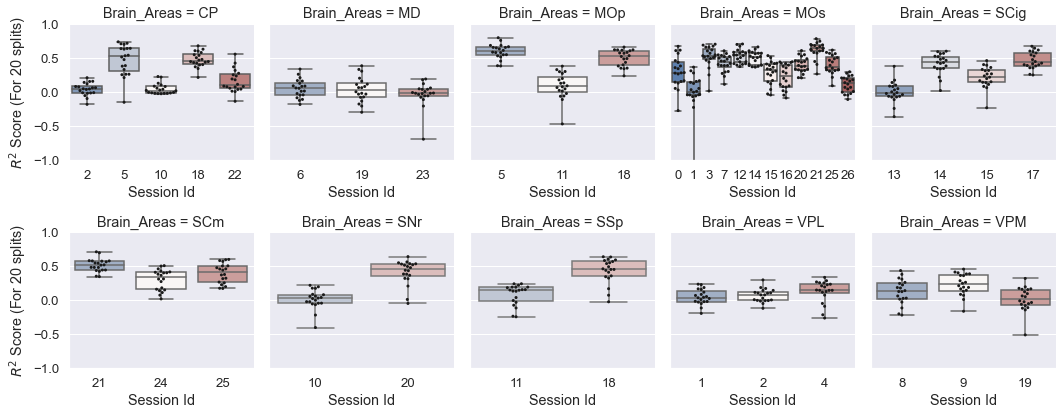

In [9]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Brain_Areas",sharex=False,col_wrap=5)
g.map(sns.boxplot, '#Session_Number','R2_score',whis=[0, 100], palette="vlag")
g.map(sns.swarmplot, '#Session_Number','R2_score', size=3, color="k", linewidth=0)
g.set(ylim=(-1,1))
g.set(xlabel="Session Id")
g.axes[0].set_ylabel(r"$R^2$ Score (For 20 splits)")
g.axes[5].set_ylabel(r"$R^2$ Score (For 20 splits)")
plt.tight_layout()
plt.show()

### Analysis of Optimal Temporal History

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


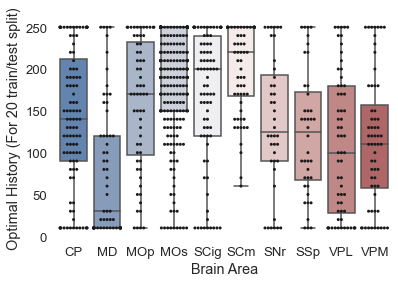

In [10]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((0,26))
sns.boxplot(x='Brain_Areas',y='Optimal_d',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='Optimal_d',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Optimal History (For 20 train/test split)")
plt.xlabel('Brain Area')
plt.gca().set_yticklabels([0,50,100,150,200,250])
plt.show()

The optimal kernel size seems to be variable for different brain regions.

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


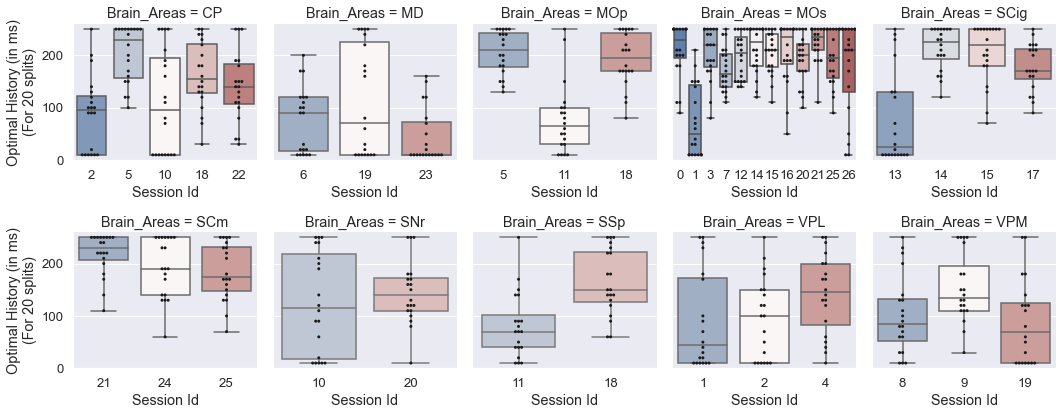

In [11]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Brain_Areas",sharex=False,col_wrap=5)
g.map(sns.boxplot, '#Session_Number','Optimal_d',whis=[0, 100], palette="vlag")
g.map(sns.swarmplot, '#Session_Number','Optimal_d', size=3, color="k", linewidth=0)
g.set(ylim=(0,26))
g.set(xlabel="Session Id")
g.axes[0].set_ylabel("Optimal History (in ms)\n(For 20 splits)")
g.axes[0].set_yticklabels([0,100,200])
g.axes[5].set_ylabel("Optimal History (in ms)\n(For 20 splits)")
g.axes[5].set_yticklabels([0,100,200])
plt.tight_layout()
plt.show()

There is clear sensitivity to session id.

### Kernel Information Analysis

Here we try to quantify the information stored in the coefficients of the Linear Model coefficients. We look at the temporal coefficients for the 50 neurons and quantify the amount of information in the distribution of coefficients. If there is a diverity of kernels, we can suggest that different neurons are responsible for different properties of the motor output. We quantify the information in kernels by considering different metrics for information such as average entropy of coefficient distribution over time, average variability in coefficients over time, and fraction of PCs required to explain 90% variability. 

In [12]:
def mean_entropy(x):
    entropy = []
    for n,i in enumerate(np.array(np.split(x.coef_[1:],50)).T):
        p = np.histogram(i,bins=np.linspace(-10,10,100))[0]
        p = p/p.sum()
        entropy.append(stats.entropy(p))
    return np.mean(entropy)

def net_variability(x):
    coefs = np.array(np.split(x.coef_[1:],50))
    return np.std(coefs,axis=0).mean()

def PCA_90percent(x):
    X = np.array(np.split(x.coef_[1:],50)).T
    if X.shape[0]>1:
        model = PCA()
        model.fit(X)
        return np.mean(np.cumsum(model.explained_variance_ratio_)<0.9)
    else:
        return np.nan

In [13]:
df['mean_entropy'] = df['Model'].map(mean_entropy)
df['mean_variability'] = df['Model'].map(net_variability)
df['pca_participation'] = df['Model'].map(PCA_90percent)

#### Mean Entropy, Variablity and Participation Fraction Analysis

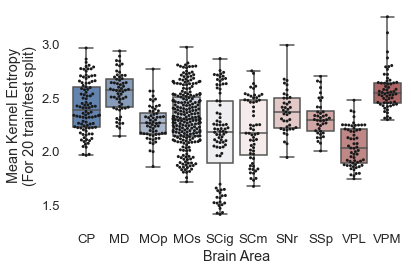

In [14]:
sns.set(font_scale=1.2)
sns.boxplot(x='Brain_Areas',y='mean_entropy',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='mean_entropy',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Mean Kernel Entropy\n(For 20 train/test split)")
plt.xlabel('Brain Area')
plt.show()

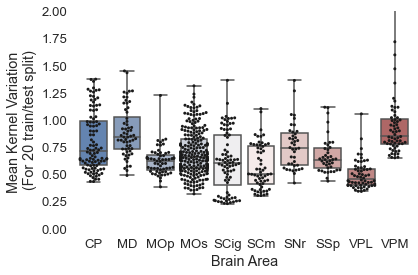

In [15]:
sns.set(font_scale=1.2)
plt.gca().set_ylim((0,2))
sns.boxplot(x='Brain_Areas',y='mean_variability',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='mean_variability',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("Mean Kernel Variation \n(For 20 train/test split)")
plt.xlabel('Brain Area')
plt.show()

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


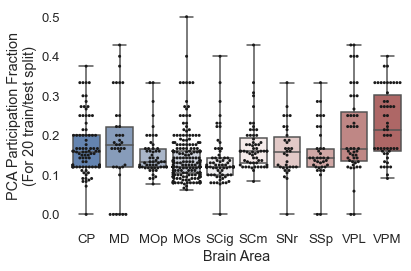

In [16]:
sns.set(font_scale=1.2)
sns.boxplot(x='Brain_Areas',y='pca_participation',data=df,whis=[0, 100], palette="vlag", order=np.unique(df.Brain_Areas))
sns.swarmplot(x='Brain_Areas',y='pca_participation',data=df, size=3, color="k", linewidth=0, order=np.unique(df.Brain_Areas))
plt.box(False)
plt.ylabel("PCA Participation Fraction\n(For 20 train/test split)")
plt.xlabel('Brain Area')
plt.show()

#### Correlation between information measures

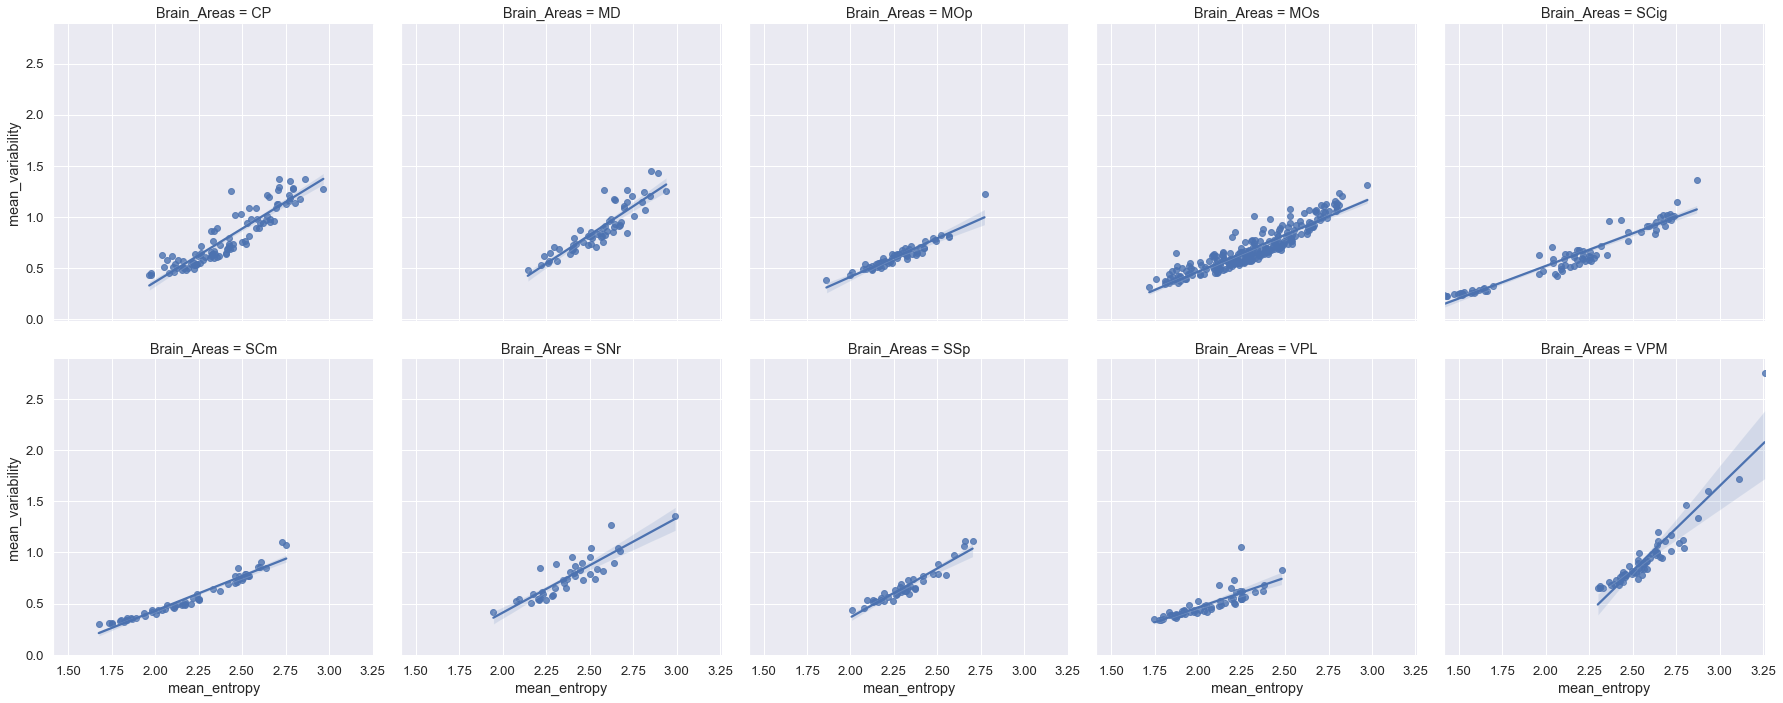

In [17]:
g = sns.lmplot('mean_entropy','mean_variability',data=df,col='Brain_Areas',col_wrap=5)

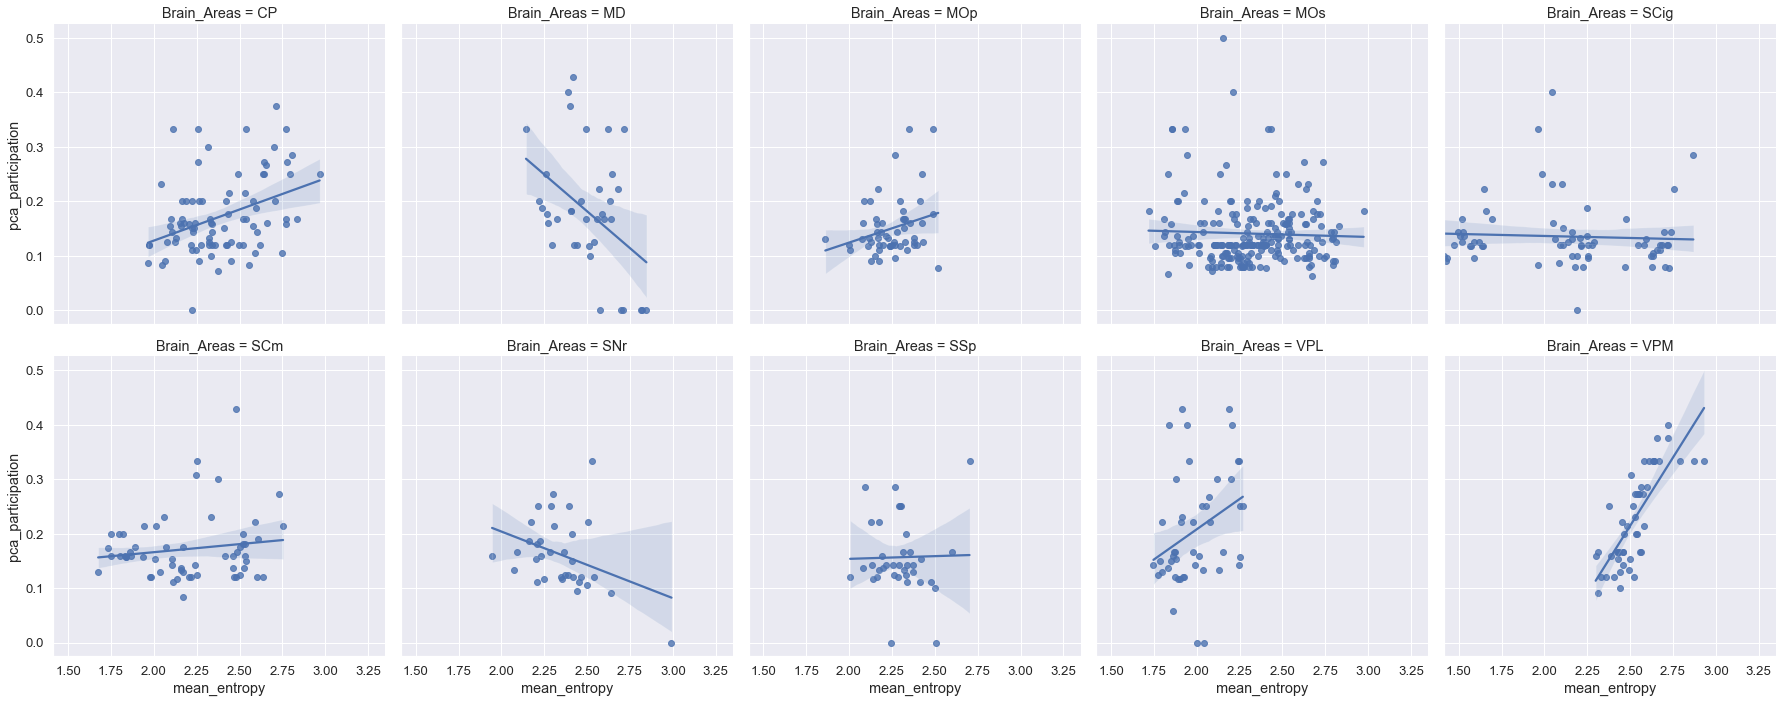

In [18]:
g = sns.lmplot('mean_entropy','pca_participation',data=df,col='Brain_Areas',col_wrap=5)

#### Sensitivity to Session ID

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


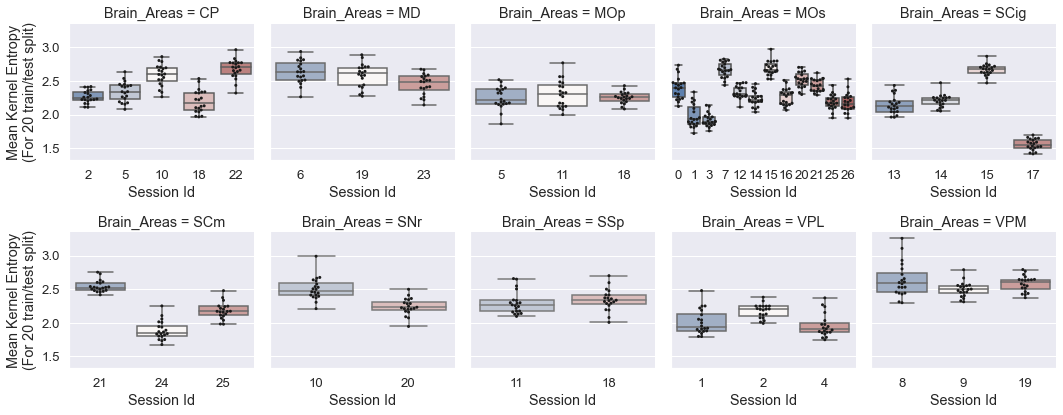

In [19]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Brain_Areas",sharex=False,col_wrap=5)
g.map(sns.boxplot, '#Session_Number','mean_entropy',whis=[0, 100], palette="vlag")
g.map(sns.swarmplot, '#Session_Number','mean_entropy', size=3, color="k", linewidth=0)
g.set(xlabel="Session Id")
g.axes[0].set_ylabel("Mean Kernel Entropy\n(For 20 train/test split)")
g.axes[5].set_ylabel("Mean Kernel Entropy\n(For 20 train/test split)")
plt.tight_layout()
plt.show()

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


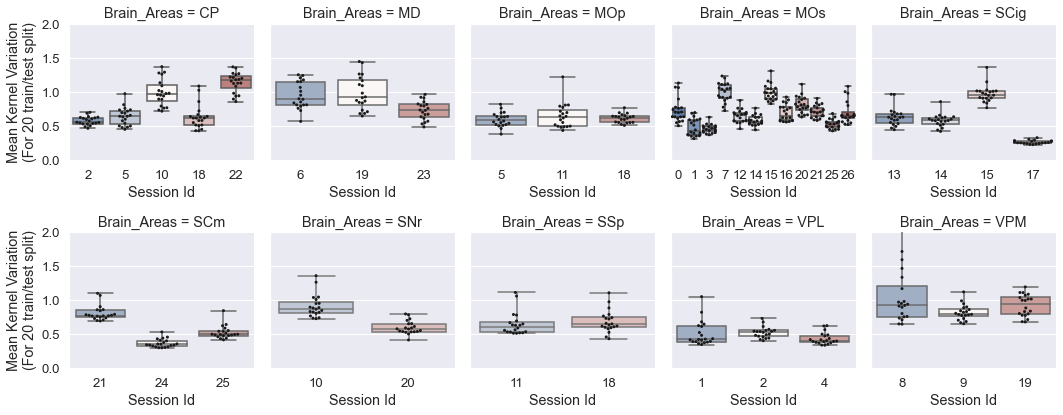

In [20]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Brain_Areas",sharex=False,col_wrap=5)
g.map(sns.boxplot, '#Session_Number','mean_variability',whis=[0, 100], palette="vlag")
g.map(sns.swarmplot, '#Session_Number','mean_variability', size=3, color="k", linewidth=0)
g.set(ylim=(0,2))
g.set(xlabel="Session Id")
g.axes[0].set_ylabel("Mean Kernel Variation\n(For 20 train/test split)")
g.axes[5].set_ylabel("Mean Kernel Variation\n(For 20 train/test split)")
plt.tight_layout()
plt.show()

D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
D:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


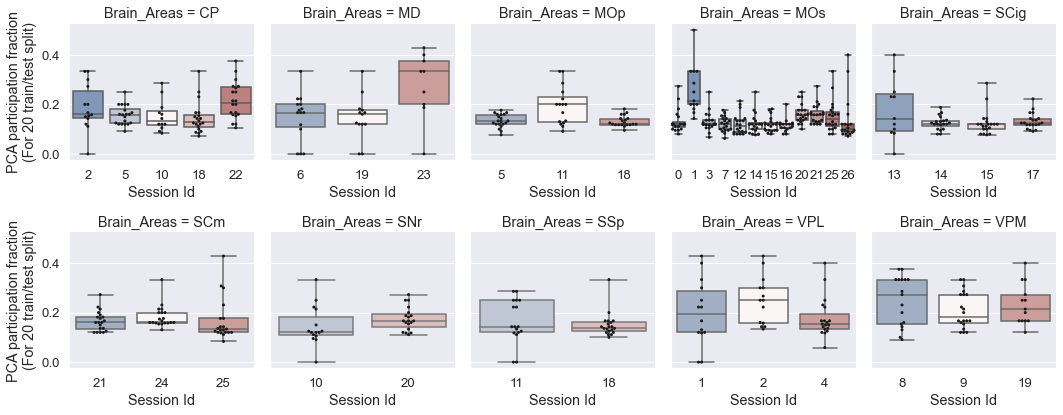

In [21]:
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Brain_Areas",sharex=False,col_wrap=5)
g.map(sns.boxplot, '#Session_Number','pca_participation',whis=[0, 100], palette="vlag")
g.map(sns.swarmplot, '#Session_Number','pca_participation', size=3, color="k", linewidth=0)
g.set(xlabel="Session Id")
g.axes[0].set_ylabel("PCA participation fraction\n(For 20 train/test split)")
g.axes[5].set_ylabel("PCA participation fraction\n(For 20 train/test split)")
plt.tight_layout()
plt.show()

### Whats the Nature of the Kernels

We look at the PCAs of the Kernels but to be able to compare them, we need to see how similar the PCA components are so we plot them. To be able to compare the variety of kernel sizes, we use linear interpolation to normalize the size of the kernels.

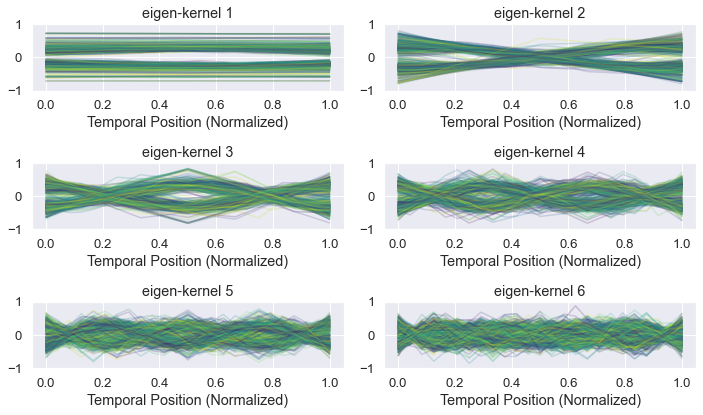

In [22]:
fig = plt.figure(figsize=(10,6))
ax = [fig.add_subplot(3,2,i) for i in range(1,7)]
data = [None for i in range(6)]
for i in range(df.shape[0]):
    X = np.array(np.split(df.Model[i].coef_[1:],50))
    if X.shape[1]<2:
        continue
    model = PCA()
    model.fit(X)
    for j in range(6):
        if j>=model.components_.shape[0]:
            continue
        x = np.linspace(0, 1,model.components_.shape[0])
        y = model.components_[j]
        f = interp1d(x, y)
        ax[j].plot(np.linspace(0,1,25),f(np.linspace(0,1,25)),color=plt.cm.viridis(np.random.uniform()),alpha=0.2)

for n,i in enumerate(ax):
    i.set_ylim((-1,1))
    i.set_xlabel("Temporal Position (Normalized)")
    i.set_title(f"eigen-kernel {n+1}")

plt.tight_layout()
plt.show()

A strange result becons! It seems like the Eigenvectors are very similar across brain regions down to a reflective symmetry and seem to have a period multiplying feature. This is surprising but not something completely unexpected due to the orthogonality condition of PCA. And since sinusoids are orthogonal to each other and can be used to create any temporal pattern (by fourier analysis). The symmetry is also expected because of the symmetric nature of the output be we need to be sure if it is really the case or just and illusion. So lets isolate the reflective symmetry.

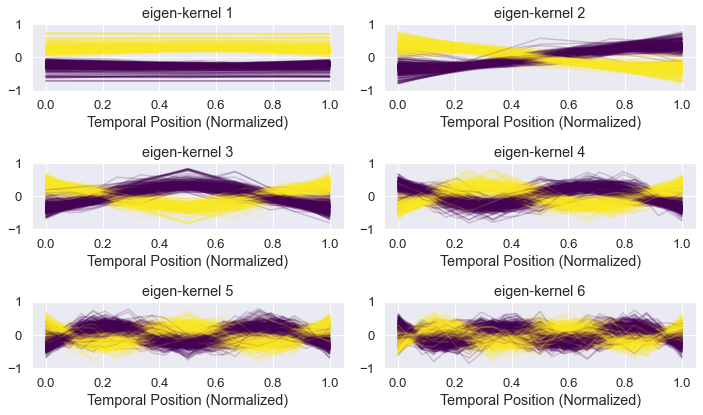

In [23]:
fig = plt.figure(figsize=(10,6))
ax = [fig.add_subplot(3,2,i) for i in range(1,7)]
data = [None for i in range(6)]
for i in range(df.shape[0]):
    X = np.array(np.split(df.Model[i].coef_[1:],50))
    if X.shape[1]<2:
        continue
    model = PCA()
    model.fit(X)
    for j in range(6):
        if j>=model.components_.shape[0]:
            continue
        x = np.linspace(0, 1,model.components_.shape[0])
        y = model.components_[j]
        f = interp1d(x, y)
        if data[j] is None:
            data[j] = [f(np.linspace(0,1,25))]
        else:
            ry = [f(np.linspace(0,1,25)),-f(np.linspace(0,1,25))]
            mean = np.mean(data[j],axis=0)
            better = np.argmin([np.mean((ry[0]-mean)**2),np.mean((ry[1]-mean)**2)])
            ax[j].plot(np.linspace(0,1,25),ry[0],color=plt.cm.viridis(float(better)),alpha=0.2)
            data[j].append(ry[better])

for n,i in enumerate(ax):
    i.set_ylim((-1,1))
    i.set_xlabel("Temporal Position (Normalized)")
    i.set_title(f"eigen-kernel {n+1}")

plt.tight_layout()
plt.show()

Now lets correct it.

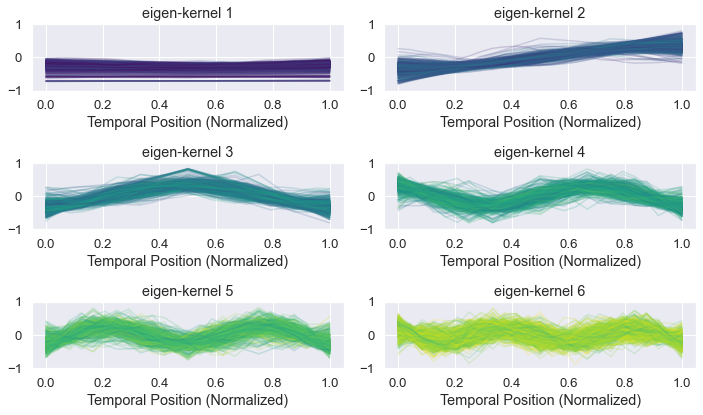

In [24]:
fig = plt.figure(figsize=(10,6))
ax = [fig.add_subplot(3,2,i) for i in range(1,7)]
data = [None for i in range(6)]
for i in range(df.shape[0]):
    X = np.array(np.split(df.Model[i].coef_[1:],50))
    if X.shape[1]<2:
        continue
    model = PCA()
    model.fit(X)
    for j in range(6):
        if j>=model.components_.shape[0]:
            continue
        x = np.linspace(0, 1,model.components_.shape[0])
        y = model.components_[j]
        f = interp1d(x, y)
        if data[j] is None:
            data[j] = [f(np.linspace(0,1,25))]
        else:
            ry = [f(np.linspace(0,1,25)),-f(np.linspace(0,1,25))]
            mean = np.mean(data[j],axis=0)
            better = np.argmin([np.mean((ry[0]-mean)**2),np.mean((ry[1]-mean)**2)])
            ax[j].plot(np.linspace(0,1,25),ry[better],color=plt.cm.viridis((j+1)/7+0.1*np.random.normal()),alpha=0.2)
            data[j].append(ry[better])
for n,i in enumerate(ax):
    i.set_ylim((-1,1))
    i.set_xlabel("Temporal Position (Normalized)")
    i.set_title(f"eigen-kernel {n+1}")
        
plt.tight_layout()
plt.show()

This seems to suggest that the kernels lie on a very similar space even after kernel normalization. This means we can compare kernel normalized with respect to time and account for reflective symmetry.

In [25]:
kernels_all = []

for i in range(df.shape[0]):
    kernels = np.split(df.Model[i].coef_[1:],50)
    for j in range(len(kernels)):
        x = np.linspace(0, 1,len(kernels[j]))
        y = kernels[j]
        if len(kernels[j]) == 1:
            x = np.linspace(0, 1,2)
            y = [kernels[j][0],kernels[j][0]]
        f = interp1d(x, y)
        kernels[j] = f(np.linspace(0,1,25))
    kernels_all.append(np.array(kernels))

kernels_all = np.concatenate(kernels_all)

shuffledindex = np.random.choice(range(len(kernels_all)),replace=False,size=len(kernels_all))
kernels_all = kernels_all[shuffledindex]

In [26]:
def similarity_measure(x,y):
    if np.std(x)==0 or np.std(y)==0:
        return 0
    return np.abs(np.corrcoef(x,y)[0,1])

In [34]:
for n,i in enumerate(np.split(kernels_all,100)):
    np.save(f"../results/kernel_blocks/block_{n}",i)

In [41]:
from tqdm import tqdm 
indices  = []
for i in range(100):
    for j in range(i+1):
        indices.append((i,j))

In [43]:
%%time
for i,j in tqdm(indices):
    kernels_block_a = np.load(f"../results/kernel_blocks/block_{i}.npy")
    kernels_block_b = np.load(f"../results/kernel_blocks/block_{j}.npy")

    assert kernels_block_b.shape[0] == kernels_block_a.shape[0], "Matrix should be square"

    similarity_matrix = np.zeros((kernels_block_a.shape[0],kernels_block_b.shape[0]))

    for x in range(kernels_block_a.shape[0]):
        for y in range(kernels_block_b.shape[0]):
            similarity_matrix[x,y] = similarity_measure(kernels_block_a[x],kernels_block_b[y])

    np.save(f'../results/similarity_blocks/{i}block{j}',similarity_matrix)

100%|███████████████████████████████████████████████████████████████████████████| 5050/5050 [28:06:29<00:00, 20.04s/it]

Wall time: 1d 4h 6min 29s


In [44]:
def similarity_measure_scaled(x,y):
    return np.min([np.mean((x-y)**2),np.mean((x+y)**2)])

In [45]:
%%time
for i,j in tqdm(indices):
    kernels_block_a = np.load(f"../results/kernel_blocks/block_{i}.npy")
    kernels_block_b = np.load(f"../results/kernel_blocks/block_{j}.npy")

    assert kernels_block_b.shape[0] == kernels_block_a.shape[0], "Matrix should be square"

    similarity_matrix = np.zeros((kernels_block_a.shape[0],kernels_block_b.shape[0]))

    for x in range(kernels_block_a.shape[0]):
        for y in range(kernels_block_b.shape[0]):
            similarity_matrix[x,y] = similarity_measure_scaled(kernels_block_a[x],kernels_block_b[y])

    np.save(f'../results/similarity_blocks_scaled/{i}block{j}',similarity_matrix)

100%|████████████████████████████████████████████████████████████████████████████| 5050/5050 [6:34:12<00:00,  4.68s/it]

Wall time: 6h 34min 12s
